# Imports

In [1]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

import talib
import trendln

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shap
import torch
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# print the JS visualization code to the notebook
shap.initjs()
%matplotlib inline

# Functions

In [2]:
def get_user_inputs():
    live = input('Do you want live data?: yes/ no/ max\n')
    if(live == 'max'):
        g_type = 'line'
    else:
        g_type = 'candle'
    return(live, g_type)

def pull_price_data(live, stock_ticker, mode = 'normal'):
    
    if(type(stock_ticker) != str):
        ticker = list(company_dict.keys())[list(company_dict.values()).index(stock_ticker.value)]
        ticker += '.NS'
    else:
        ticker = stock_ticker
    if(live == 'no'):
        if(mode == 'scoring'):
            start = datetime.date.today() - datetime.timedelta(weeks = 24)
            end = datetime.date.today() + datetime.timedelta(days = 1)
            interval = '1d'
        else:
            period = input("Enter period of months")
            start = datetime.date.today() - datetime.timedelta(weeks = int(period)*4)
            end = datetime.date.today() + datetime.timedelta(days = 1)
            interval = input("Enter interval(1m, 1d, 1wk)")
        data = yf.download(tickers=ticker, start = start, end =end, interval=interval)
    elif(live == 'yes'):            
        data = yf.download(tickers=ticker, period = '1d', interval='1m')
        data.set_index(pd.Series(data.index).apply(lambda x: x.replace(tzinfo=None)), inplace = True)
        data.index.name = 'Date'
    elif(live == 'max'):
        if(mode == 'scoring'):
            interval = '1d'
        else:
            interval = input("Enter interval(1d, 1wk)")
        data = yf.download(tickers=ticker, period = 'max', interval=interval)
    return(data)

def create_indicator_df(data, time_period_multiplier = 1):
    data['upperband'], data['middleband'], data['lowerband'] = talib.BBANDS(data['Adj Close'], timeperiod=(20*time_period_multiplier), nbdevup=2, nbdevdn=2, matype=0)
#     data['DEMA'] = talib.DEMA(data['Adj Close'], timeperiod=(30*time_period_multiplier))
    data['EMA'] = talib.EMA(data['Adj Close'], timeperiod=(30*time_period_multiplier))
    data['HT_TRENDLINE'] = talib.HT_TRENDLINE(data['Adj Close'])
#     data['KAMA'] = talib.KAMA(data['Adj Close'], timeperiod=(30*time_period_multiplier))
#     data['MA'] = talib.MA(data['Adj Close'], timeperiod=(30*time_period_multiplier), matype=0)
#     data['MIDPOINT'] = talib.MIDPOINT(data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['SAR'] = talib. SAR(data['High'], data['Adj Close'], acceleration=0.02, maximum=0.2)
#     data['SMA'] = talib.SMA(data['Adj Close'], timeperiod=(30*time_period_multiplier))
    #data['TEMA'] = talib.TEMA(data['Adj Close'], timeperiod=(30*time_period_multiplier))
#     data['TRIMA'] = talib.TRIMA(data['Adj Close'], timeperiod=(30*time_period_multiplier))
#     data['WMA'] = talib.WMA(data['Adj Close'], timeperiod=(30*time_period_multiplier))
#     data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=(14*time_period_multiplier))
    data['ADXR'] = talib.ADXR(data['High'], data['Low'], data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['APO'] = talib.APO(data['Adj Close'], fastperiod=(12*time_period_multiplier), slowperiod=(26*time_period_multiplier), matype=0)
#     data['aroondown'], data['aroonup'] = talib.AROON(data['High'], data['Low'], timeperiod=(14*time_period_multiplier))
#     data['AROONOSC'] = talib.AROONOSC(data['High'], data['Low'], timeperiod=(14*time_period_multiplier))
#     data['BOP'] = talib.BOP(data['Open'], data['High'], data['Low'], data['Adj Close'])
#     data['CCI'] = talib.CCI(data['High'], data['Low'], data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['CMO'] = talib.CMO(data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['DX'] = talib.DX(data['High'], data['Low'], data['Adj Close'], timeperiod=(14*time_period_multiplier))
    data['macd'], data['macdsignal'], data['macdhist'] = talib.MACD(data['Adj Close'], fastperiod=(12*time_period_multiplier), slowperiod=(26*time_period_multiplier), signalperiod=(9*time_period_multiplier))
#     data['MOM'] = talib.MOM(data['Adj Close'], timeperiod=(10*time_period_multiplier))                    
#     data['ROC'] = talib.ROC(data['Adj Close'], timeperiod=(10*time_period_multiplier))
    data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=(14*time_period_multiplier))     
#     data['ULTOSC'] = talib.ULTOSC(data['High'], data['Low'], data['Adj Close'], timeperiod1=(7*time_period_multiplier), timeperiod2=(14*time_period_multiplier), timeperiod3=(28*time_period_multiplier))
#     data['WILLR'] = talib.WILLR(data['High'], data['Low'], data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])      
#     data['ADOSC'] = talib.ADOSC(data['High'], data['Low'], data['Adj Close'], data['Volume'],  fastperiod=(3*time_period_multiplier), slowperiod=(10*time_period_multiplier))
#     data['AD'] = talib.AD(data['High'], data['Low'], data['Adj Close'], data['Volume'])
#     data['HT_DCPERIOD'] = talib.HT_DCPERIOD(data['Adj Close'])
#     data['HT_DCPHASE'] = talib.HT_DCPHASE(data['Adj Close'])
#     data['inphase'], data['quadrature'] = talib.HT_PHASOR(data['Adj Close'])        
#     data['sine'], data['leadsine'] = talib.HT_SINE(data['Adj Close'])    
#     data['HT_TRENDMODE'] = talib.HT_TRENDMODE(data['Adj Close'])        
#     for pat in talib.get_function_groups()['Pattern Recognition']:
#         candlestick_function = getattr(talib, pat)
#         data[pat] = candlestick_function(data['Open'], data['High'], data['Low'], data['Adj Close'])    
#     data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['NATR'] = talib.NATR(data['High'], data['Low'], data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['TRANGE'] = talib.TRANGE(data['High'], data['Low'], data['Adj Close'])

#     data['BETA'] = talib.BETA(data['High'], data['Low'], timeperiod=(5*time_period_multiplier))
#     data['CORREL'] = talib.CORREL(data['High'], data['Low'], timeperiod=(30*time_period_multiplier))
#     data['LINEARREG'] = talib.LINEARREG(data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(data['Adj Close'], timeperiod=(14*time_period_multiplier))
#     data['STDDEV'] = talib.STDDEV(data['Adj Close'], timeperiod=(5*time_period_multiplier), nbdev=1)
#     data['TSF'] = talib.TSF(data['Adj Close'], timeperiod=(14*time_period_multiplier))
    #data['VAR'] = talib.VAR(data['Adj Close'], timeperiod=(5*time_period_multiplier), nbdev=1)
#     data['MAX'] = talib.MAX(data['Adj Close'], timeperiod=(30*time_period_multiplier))
#     data['MIN'] = talib.MIN(data['Adj Close'], timeperiod=(30*time_period_multiplier))
    #data['Target'] = data['Adj Close'].shift(2)
    return(data)

def create_target_variable(data, period = 5):
    signals = {5:'5_day_signal', 10:'10_day_signal', 15:'15_day_signal', 30:'30_day_signal', 60:'60_day_signal'}
    temp = []
    for i in range(len(data) - period):
        if(data['Close'].iloc[i] < data['Close'].iloc[i+period]):
            temp.append(1)
        else:
            temp.append(0)
    
    for i in range(period):
        temp.append(np.nan)
    
    data[signals[period]] =  temp
    return(data)

def return_ticker_list(csv_file):
    if(csv_file == 'NASDAQ 100 Tickers.csv'):
        ticker_list = []
        n_companies = pd.read_csv(csv_file) # Getting tickers from csv
        for t in n_companies['Symbol'].values:
            ticker_list.append(t)
    else:
        ticker_list = []
        n_companies = pd.read_csv(csv_file) # Getting tickers from csv
        for t in n_companies['Symbol'].values:
            ticker_list.append(t+'.NS') # Need to add .NS to get Nifty data
    return(ticker_list)

# Get Stock Data

In [60]:
#Getting data of single stock
live, g_type = get_user_inputs()
data = pull_price_data(live, stock_ticker = 'INFY.NS')
data.head()

Do you want live data?: yes/ no/ max
no
Enter period of months4
Enter interval(1m, 1d, 1wk)1d
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-06,1855.000000,1857.500000,1822.150024,1828.849976,1809.684692,5407453
2022-04-07,1821.050049,1828.150024,1807.550049,1811.000000,1792.021729,5797544
2022-04-08,1823.000000,1838.000000,1808.000000,1814.599976,1795.583984,5131446
2022-04-11,1814.000000,1814.000000,1762.550049,1766.550049,1748.037598,8248407
2022-04-12,1757.500000,1757.500000,1727.750000,1742.449951,1724.190063,6456184


# Creating df from talib indicators

In [3]:
print("TAlib available functions")
talib.get_function_groups()

TAlib available functions


{'Cycle Indicators': ['HT_DCPERIOD',
  'HT_DCPHASE',
  'HT_PHASOR',
  'HT_SINE',
  'HT_TRENDMODE'],
 'Math Operators': ['ADD',
  'DIV',
  'MAX',
  'MAXINDEX',
  'MIN',
  'MININDEX',
  'MINMAX',
  'MINMAXINDEX',
  'MULT',
  'SUB',
  'SUM'],
 'Math Transform': ['ACOS',
  'ASIN',
  'ATAN',
  'CEIL',
  'COS',
  'COSH',
  'EXP',
  'FLOOR',
  'LN',
  'LOG10',
  'SIN',
  'SINH',
  'SQRT',
  'TAN',
  'TANH'],
 'Momentum Indicators': ['ADX',
  'ADXR',
  'APO',
  'AROON',
  'AROONOSC',
  'BOP',
  'CCI',
  'CMO',
  'DX',
  'MACD',
  'MACDEXT',
  'MACDFIX',
  'MFI',
  'MINUS_DI',
  'MINUS_DM',
  'MOM',
  'PLUS_DI',
  'PLUS_DM',
  'PPO',
  'ROC',
  'ROCP',
  'ROCR',
  'ROCR100',
  'RSI',
  'STOCH',
  'STOCHF',
  'STOCHRSI',
  'TRIX',
  'ULTOSC',
  'WILLR'],
 'Overlap Studies': ['BBANDS',
  'DEMA',
  'EMA',
  'HT_TRENDLINE',
  'KAMA',
  'MA',
  'MAMA',
  'MAVP',
  'MIDPOINT',
  'MIDPRICE',
  'SAR',
  'SAREXT',
  'SMA',
  'T3',
  'TEMA',
  'TRIMA',
  'WMA'],
 'Pattern Recognition': ['CDL2CROWS',
  'C

In [4]:
combined_i_data = pd.DataFrame()
combined_data5 = pd.DataFrame() # Target of +5 days
combined_data10 = pd.DataFrame() # Target of +10 days
combined_data15 = pd.DataFrame() # Target of +15 days
combined_data30 = pd.DataFrame() # Target of +30 days
combined_data60 = pd.DataFrame() # Target of +60 days
for t in return_ticker_list('n50.csv'):
    try:
        print(t)
        temp_data = pull_price_data('max', t, mode = 'scoring')
        temp_data['Company'] = t
        i_data = create_indicator_df(temp_data, time_period_multiplier = 1)
        combined_i_data = pd.concat([combined_i_data, i_data], 
                                    axis = 0, ignore_index = True)
        data5 = create_target_variable(i_data.copy(), period = 5)
        combined_data5 = pd.concat([combined_data5, data5],
                                   axis = 0, ignore_index = True)
        data10 = create_target_variable(i_data.copy(), period = 10)
        combined_data10 = pd.concat([combined_data10, data10],
                                   axis = 0, ignore_index = True)
        data15 = create_target_variable(i_data.copy(), period = 15)
        combined_data15 = pd.concat([combined_data15, data15], 
                                   axis = 0, ignore_index = True)
        data30 = create_target_variable(i_data.copy(), period = 30)
        combined_data30 = pd.concat([combined_data30, data30], 
                                   axis = 0, ignore_index = True)
        data60 = create_target_variable(i_data.copy(), period = 60)
        combined_data60 = pd.concat([combined_data60, data60], 
                                   axis = 0, ignore_index = True)
        
        combined_i_data['Volume'] = combined_i_data['Volume'].apply(lambda x: np.nan if x == 0 else x)
        combined_data5['Volume'] = combined_data5['Volume'].apply(lambda x: np.nan if x == 0 else x)
        combined_data10['Volume'] = combined_data10['Volume'].apply(lambda x: np.nan if x == 0 else x)
        combined_data15['Volume'] = combined_data15['Volume'].apply(lambda x: np.nan if x == 0 else x)
        combined_data30['Volume'] = combined_data30['Volume'].apply(lambda x: np.nan if x == 0 else x)
        combined_data60['Volume'] = combined_data60['Volume'].apply(lambda x: np.nan if x == 0 else x)
        
    except:
        print("No data for ", t)
        continue
    
# Saving Saved CSVs
combined_i_data.to_csv('combined_i_data.csv', index = False)
combined_data5.to_csv('combined_data5.csv', index = False)
combined_data10.to_csv('combined_data10.csv', index = False)
combined_data15.to_csv('combined_data15.csv', index = False)
combined_data30.to_csv('combined_data30.csv', index = False)
combined_data60.to_csv('combined_data60.csv', index = False)

ACC.NS
[*********************100%***********************]  1 of 1 completed
ABBOTINDIA.NS
[*********************100%***********************]  1 of 1 completed
ADANIENT.NS
[*********************100%***********************]  1 of 1 completed
ADANIGREEN.NS
[*********************100%***********************]  1 of 1 completed
ADANITRANS.NS
[*********************100%***********************]  1 of 1 completed
ALKEM.NS
[*********************100%***********************]  1 of 1 completed
AMBUJACEM.NS
[*********************100%***********************]  1 of 1 completed
APOLLOHOSP.NS
[*********************100%***********************]  1 of 1 completed
AUROPHARMA.NS
[*********************100%***********************]  1 of 1 completed
DMART.NS
[*********************100%***********************]  1 of 1 completed
BAJAJHLDNG.NS
[*********************100%***********************]  1 of 1 completed
BANDHANBNK.NS
[*********************100%***********************]  1 of 1 completed
BERGEPAINT.NS
[*********

In [4]:
combined_i_data

,Open,High,Low,Close,Adj Close,Volume,Company,upperband,middleband,lowerband,EMA,HT_TRENDLINE,ADXR,macd,macdsignal,macdhist,RSI
0,160.000000,163.000000,159.000000,161.750000,108.968056,659631.0,ACC.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,161.050003,163.350006,160.000000,160.399994,108.058594,282660.0,ACC.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,161.000000,162.000000,158.850006,159.800003,107.654396,500553.0,ACC.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,159.149994,160.899994,157.500000,158.000000,106.441742,284181.0,ACC.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,158.050003,159.750000,157.100006,157.550003,106.138596,252587.0,ACC.NS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197015,14.500000,15.000000,14.450000,14.700000,14.700000,159313294.0,YESBANK.NS,14.253135,13.1550,12.056865,13.238487,13.109837,21.953271,0.315052,0.134687,0.180365,82.100929
197016,14.850000,14.950000,13.900000,14.250000,14.250000,162099771.0,YESBANK.NS,14.411381,13.2250,12.038619,13.303746,13.193072,22.191404,0.344603,0.176670,0.167933,68.363620
197017,14.250000,14.350000,13.650000,13.700000,13.700000,85276540.0,YESBANK.NS,14.457994,13.2675,12.077006,13.329310,13.267974,21.820792,0.319954,0.205327,0.114627,56.024905
197018,13.750000,14.900000,13.700000,14.700000,14.700000,215320288.0,YESBANK.NS,14.680236,13.3675,12.054764,13.417742,13.338870,21.909513,0.376767,0.239615,0.137153,67.507691


In [3]:
# Reading Saved CSVs
combined_i_data = pd.read_csv('combined_i_data.csv')
combined_data5 = pd.read_csv('combined_data5.csv')
combined_data10 = pd.read_csv('combined_data10.csv')
combined_data15 = pd.read_csv('combined_data15.csv')
combined_data30 = pd.read_csv('combined_data30.csv')
combined_data60 = pd.read_csv('combined_data60.csv')

# EDA

### Cleaning

In [4]:
# Overall Stats of data
combined_data5.describe()

,Open,High,Low,Close,Adj Close,Volume,upperband,middleband,lowerband,EMA,HT_TRENDLINE,ADXR,macd,macdsignal,macdhist,RSI,5_day_signal
count,197020.000000,197020.000000,197020.000000,197020.000000,197020.000000,1.955720e+05,196089.000000,196089.000000,196089.000000,195599.000000,193933.000000,195060.000000,195403.000000,195403.000000,195403.000000,196334.000000,196775.000000
mean,1585.151784,1606.644849,1562.394439,1583.144048,1522.461018,4.350809e+06,1610.824973,1519.858172,1428.891371,1518.898560,1531.153218,25.750438,6.177289,6.086405,0.090885,52.511562,0.520986
std,6551.047837,6627.045787,6468.467456,6541.963662,6481.799022,2.860334e+07,6820.666240,6467.963883,6120.998257,6460.985755,6491.107823,9.500789,128.496024,120.847930,37.907273,12.374629,0.499561
min,0.234110,0.234110,0.234110,0.234110,-0.054166,1.000000e+00,-0.036607,-0.045590,-138.902282,-0.042430,0.028604,5.308732,-3575.411678,-3102.213647,-1227.351576,0.867094,0.000000
25%,66.609840,67.777779,65.220001,66.443460,50.963575,1.453132e+05,55.267642,51.006260,46.837590,51.251561,52.189173,18.724236,-1.297409,-1.173809,-0.751747,44.075294,0.000000
50%,227.050003,231.250000,223.000000,226.800003,193.914734,7.425920e+05,208.629356,193.514790,177.242134,192.880874,195.042598,23.883938,0.326311,0.337258,0.003063,52.417868,1.000000
75%,834.000000,847.000000,820.950012,833.700012,773.172363,2.870931e+06,819.895854,772.220279,723.074013,773.437629,778.998446,31.044051,4.348231,4.178366,0.787257,60.902531,1.000000
max,96770.000000,98599.953125,92750.000000,96973.851562,96728.554688,3.072938e+09,95668.700611,90311.150000,85683.751877,87985.248084,89798.684755,98.913750,4219.987721,3667.515103,1053.139728,99.888566,1.000000


In [5]:
# NaNs in data
combined_data5.isna().sum()

Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume          1448
Company            0
upperband        931
middleband       931
lowerband        931
EMA             1421
HT_TRENDLINE    3087
ADXR            1960
macd            1617
macdsignal      1617
macdhist        1617
RSI              686
5_day_signal     245
dtype: int64

Can drop all NaNs

In [6]:
combined_i_data.dropna(inplace = True)
combined_data5.dropna(inplace = True)
combined_data10.dropna(inplace = True)
combined_data15.dropna(inplace = True)
combined_data30.dropna(inplace = True)
combined_data60.dropna(inplace = True)

<AxesSubplot:>

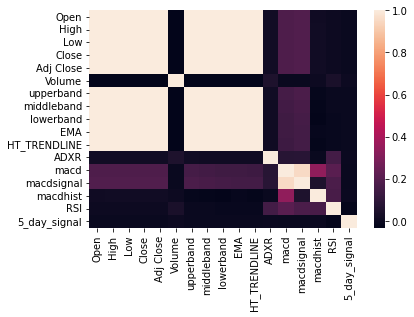

In [7]:
sns.heatmap(combined_data5.corr())

<AxesSubplot:>

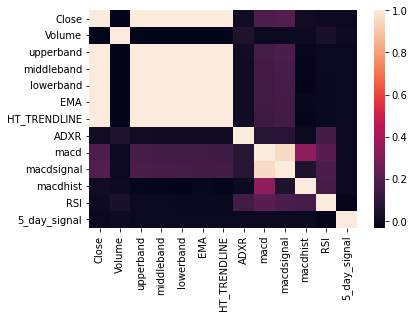

In [8]:
# Dropping Open, High, Low and Adj Close since its similar info to Close
  
combined_i_data.drop(columns = ['Open', 'High', 'Low', 'Adj Close'], inplace = True)
combined_data5.drop(columns = ['Open', 'High', 'Low', 'Adj Close'], inplace = True)
combined_data10.drop(columns = ['Open', 'High', 'Low', 'Adj Close'], inplace = True)
combined_data15.drop(columns = ['Open', 'High', 'Low', 'Adj Close'], inplace = True)
combined_data30.drop(columns = ['Open', 'High', 'Low', 'Adj Close'], inplace = True)
combined_data60.drop(columns = ['Open', 'High', 'Low', 'Adj Close'], inplace = True)
sns.heatmap(combined_data5.corr())

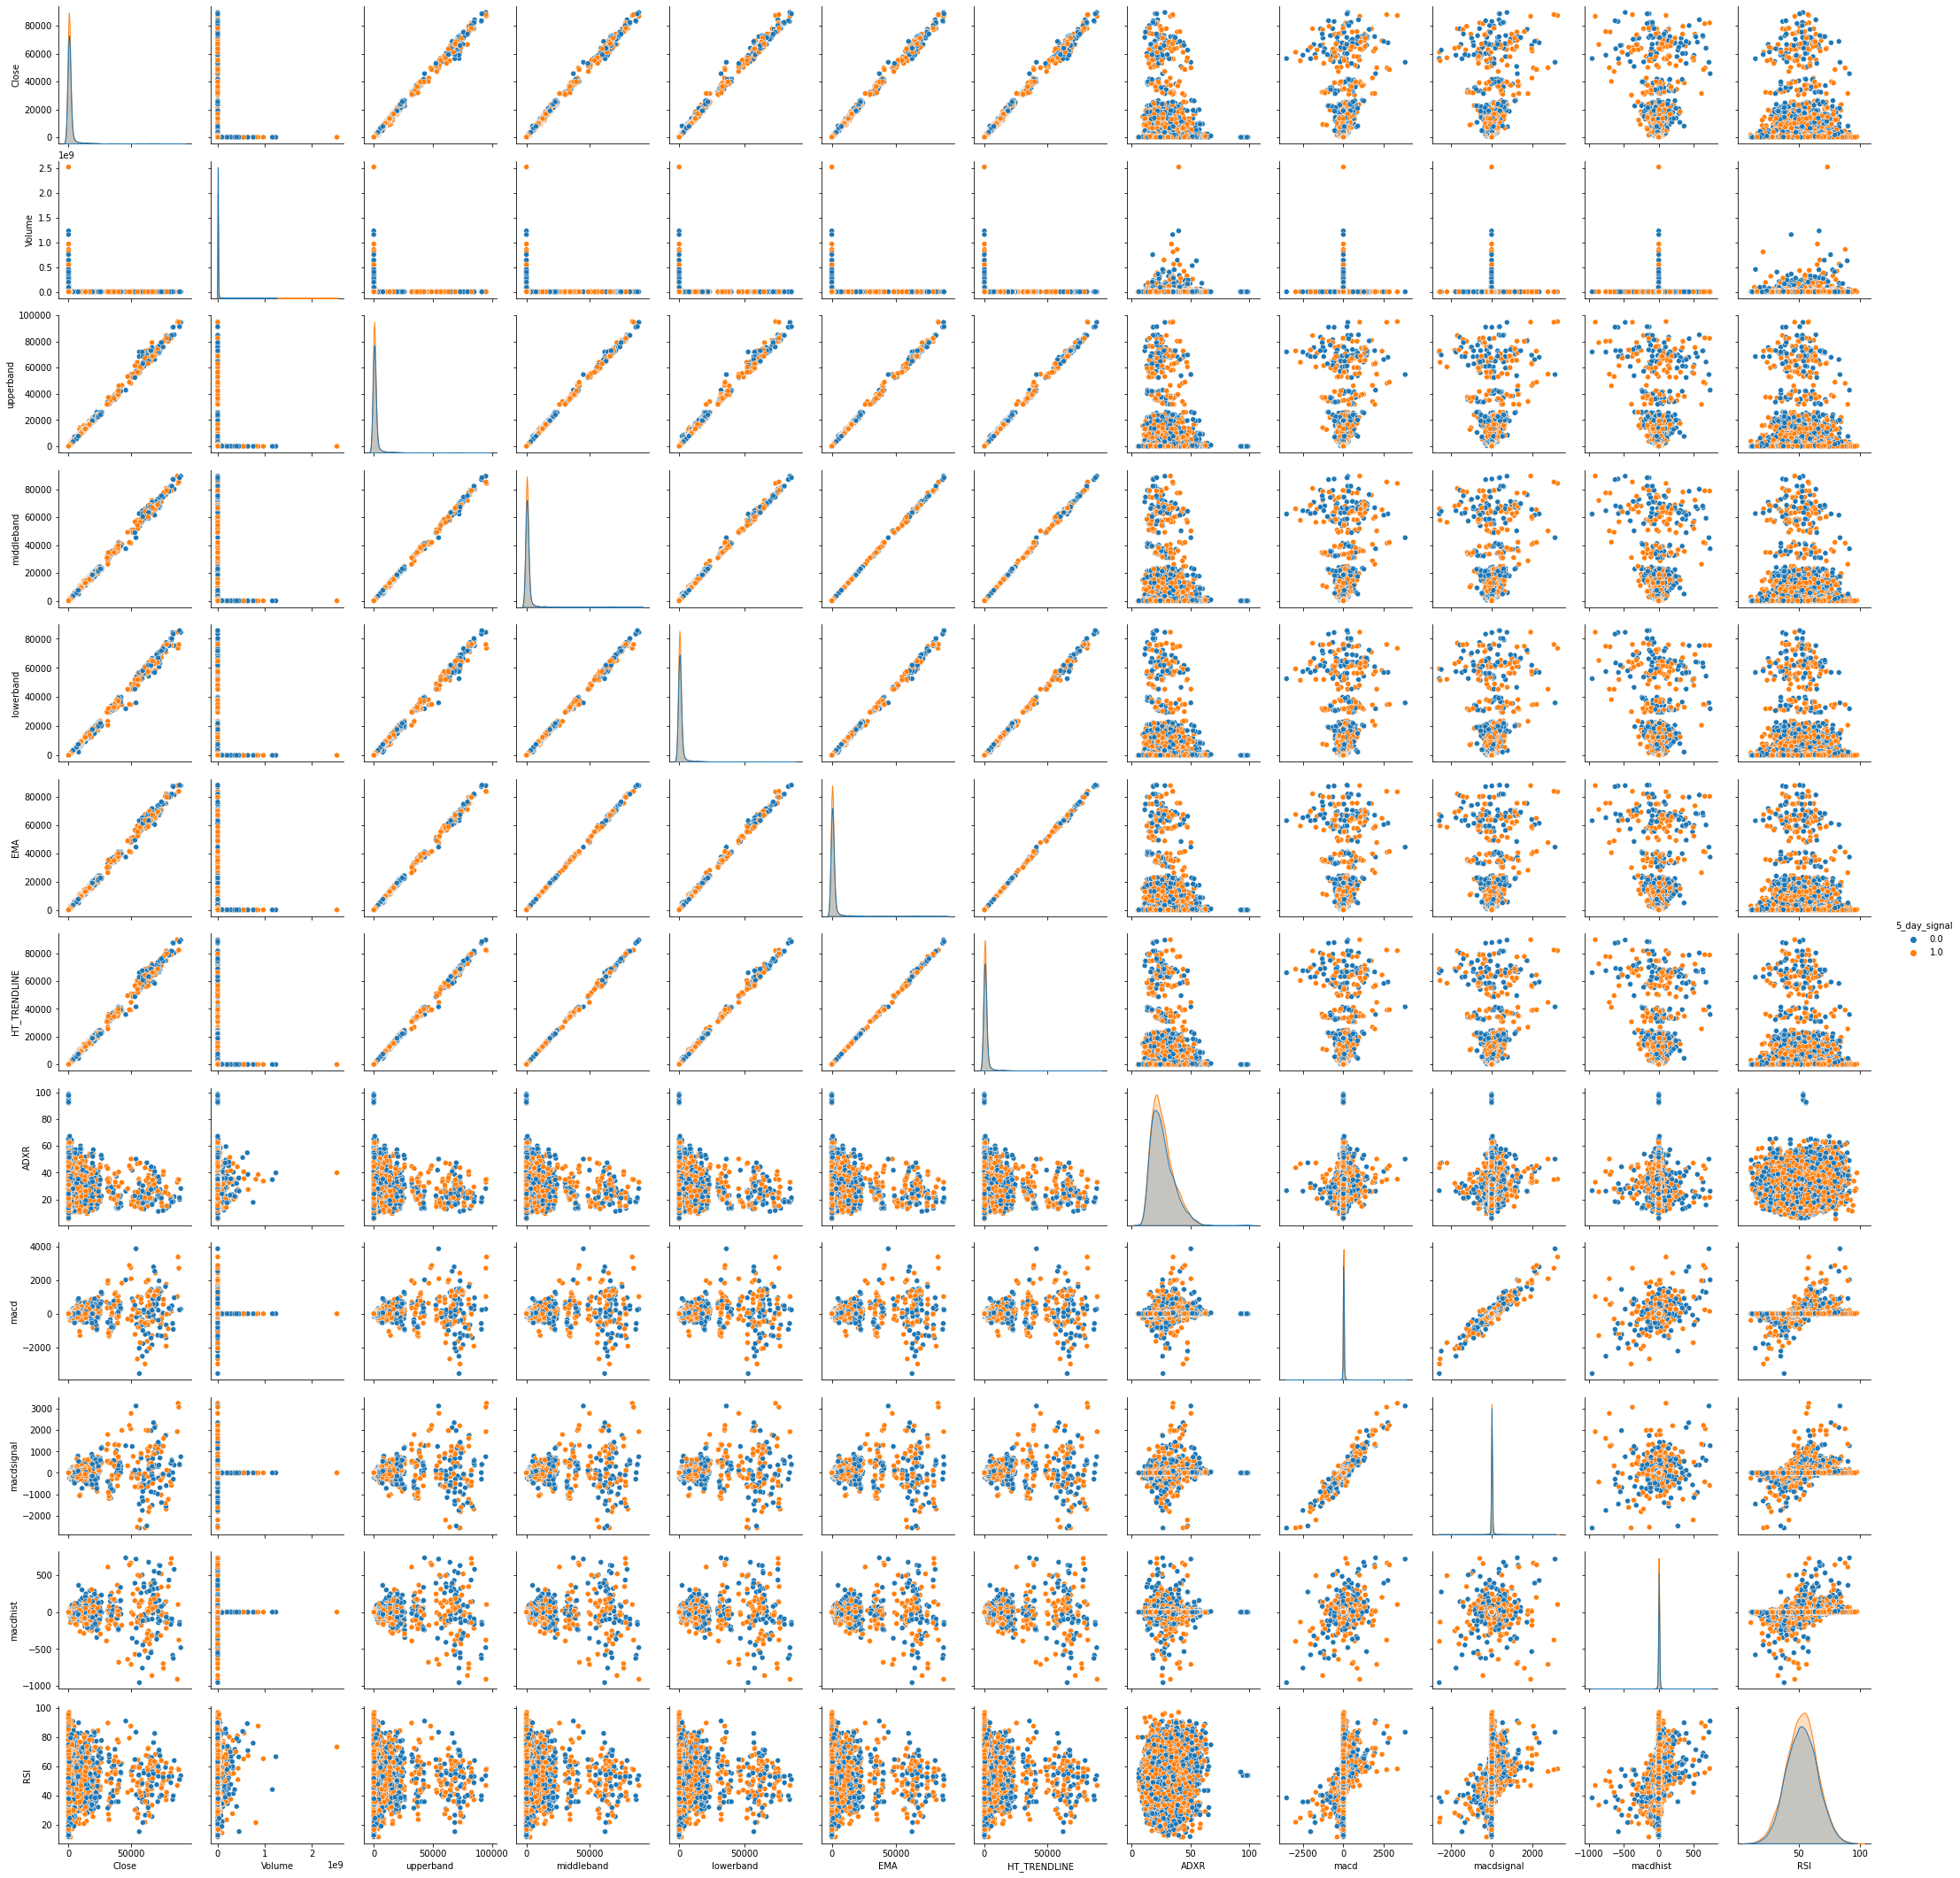

In [9]:
sns.pairplot(combined_data5.sample(frac = 0.1), hue = '5_day_signal')

In [10]:
X_train = combined_data5.iloc[0 : int(len(combined_data5) * 0.8)].drop(columns = ['5_day_signal', 'Company'])
y_train = combined_data5.iloc[0 : int(len(combined_data5) * 0.8)]['5_day_signal']
X_val = combined_data5.iloc[int(len(combined_data5) * 0.8) : int(len(combined_data5) * 0.9)].drop(columns = ['5_day_signal', 'Company'])
y_val = combined_data5.iloc[int(len(combined_data5) * 0.8) : int(len(combined_data5) * 0.9)]['5_day_signal']
X_test = combined_data5.iloc[int(len(combined_data5) * 0.9) : ].drop(columns = ['5_day_signal', 'Company'])
y_test = combined_data5.iloc[int(len(combined_data5) * 0.9) : ]['5_day_signal']
# Standardizing data for Logistic Regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [11]:
y_train.value_counts() / len(y_train)

1.0    0.523002
0.0    0.476998
Name: 5_day_signal, dtype: float64

In [12]:
y_val.value_counts() / len(y_val)

1.0    0.524198
0.0    0.475802
Name: 5_day_signal, dtype: float64

In [13]:
y_test.value_counts() / len(y_test)

1.0    0.508733
0.0    0.491267
Name: 5_day_signal, dtype: float64

Blindly investing every day would net us these many positive profits in a 5 day period. 

# Baseline 

## Logistic Regression and p-values

In [20]:
X_columns = combined_data5.drop(columns = ['5_day_signal', 'Company']).columns

         Current function value: 0.692661
         Iterations: 35


C:\Users\Abhishek\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:           5_day_signal   No. Observations:               153898
Model:                          Logit   Df Residuals:                   153888
Method:                           MLE   Df Model:                            9
Date:                Thu, 28 Jul 2022   Pseudo R-squ.:              -0.0008271
Time:                        14:33:41   Log-Likelihood:            -1.0660e+05
converged:                      False   LL-Null:                   -1.0651e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Close           -0.6093      0.250     -2.435      0.015      -1.100      -0.119
Volume           0.0174      0.006      3.119      0.002       0.006       0.028
upperband        0.1897   7.59e+04    2.5e-0

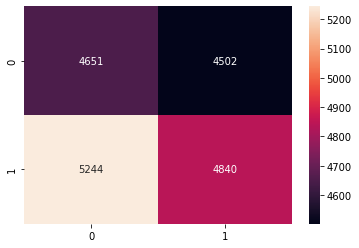

In [74]:
# building the model and fitting the data
log_reg = sm.Logit(y_train.reset_index(drop = True), 
                   pd.DataFrame(X_train, columns = X_columns).reset_index(drop = True)).fit()
print(log_reg.summary())
y_val_pred = log_reg.predict(X_val)
y_val_pred = list(map(round, y_val_pred))
print("\n\nPrecision Score :", precision_score(y_val, y_val_pred))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot = True, fmt = 'g')
plt.show()

## XGBoost

[14:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Feature Importance

Volume 0.061397772
RSI 0.062004875
macdhist 0.06794149
macd 0.069576815
ADXR 0.072822034
macdsignal 0.07648264
middleband 0.089463234
Close 0.092967466
upperband 0.09350231
lowerband 0.09605536
HT_TRENDLINE 0.09969479
EMA 0.11809128


Precision Score : 0.521729490022173


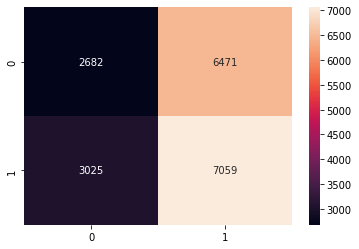

In [97]:
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False)
xgb.fit(X_train, y_train.astype(int))
print("Feature Importance\n")
feature_dict = {feature: importance for feature, importance in zip(['Close', 'Volume', 'upperband', 'middleband', 'lowerband',
       'EMA', 'HT_TRENDLINE', 'ADXR', 'macd', 'macdsignal', 'macdhist', 'RSI'], xgb.feature_importances_)}
feature_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1]))
for feature, importance in feature_dict.items():
    print(feature, importance)

y_val_pred = xgb.predict(X_val)
print("\n\nPrecision Score :", precision_score(y_val, y_val_pred))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot = True, fmt = 'g')
plt.show()

## Random Forest

Feature Importance

middleband 0.07624229571066883
HT_TRENDLINE 0.07849217162306316
EMA 0.07949932935581969
macd 0.08194738494523586
upperband 0.08224467569804829
RSI 0.08234034113899034
lowerband 0.0827972980860122
Volume 0.08285178902855662
macdhist 0.0832063982526805
macdsignal 0.08433243336751846
Close 0.09128007040824741
ADXR 0.09476581238515872


Precision Score : 0.5283684814259243


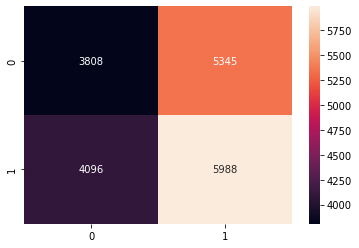

In [107]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Feature Importance\n")
feature_dict = {feature: importance for feature, importance in zip(['Close', 'Volume', 'upperband', 'middleband', 'lowerband',
       'EMA', 'HT_TRENDLINE', 'ADXR', 'macd', 'macdsignal', 'macdhist', 'RSI'], rf.feature_importances_)}
feature_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1]))
for feature, importance in feature_dict.items():
    print(feature, importance)

y_val_pred = rf.predict(X_val)
# y_val_pred = list(map(round, y_val_pred))
print("\n\nPrecision Score :", precision_score(y_val, y_val_pred))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot = True, fmt = 'g')
plt.show()

# ANN(Tensorflow)

In [17]:
ann_tensorflow = keras.Sequential()
ann_tensorflow.add(layers.Dense(30, input_shape=(12,)))
ann_tensorflow.add(layers.Dense(15, activation="relu",))
ann_tensorflow.add(layers.Dense(5, activation="relu",))
ann_tensorflow.add(layers.Dense(1, activation="sigmoid"))
ann_tensorflow.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                390       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
1203/1203 [==============================] - 20s 5ms/step - loss: 0.6943 - accuracy: 0.5210 - val_loss: 0.6924 - val_accuracy: 0.5189
Epoch 2/5
1203/1203 [==============================] - 4s 3ms/step - loss: 0.6917 - accuracy: 0.5241 - val_loss: 0.6923 - val_accuracy: 0.5239
Epoch 3/5
1203/1203 [==============================] - 4s 3ms/step - loss: 0.6917 - accuracy: 0.5237 - val_loss: 0.6927 - val_accuracy: 0.5209
Epoch 4/5
1203/1203 [==============================] - 4s 3ms/step - loss: 0.6913 - accuracy: 0.5265 - val_loss: 0.6928 - val_accuracy: 0.5234
Epoch 5/5
1203/1203 [==============================] - 5s 4ms/step - loss: 0.6914 - accuracy: 0.5242 - val_loss: 0.6924 - val_accuracy: 0.5219


Precision Score : 0.5261328148017206


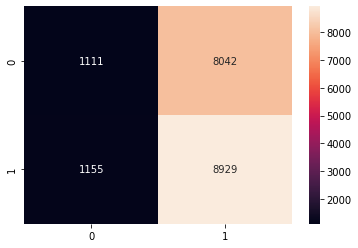

In [18]:
ann_tensorflow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = ann_tensorflow.fit(X_train, y_train, batch_size=128, verbose = 1,
                    epochs=5, validation_data=(X_val, y_val))
y_val_pred = ann_tensorflow.predict(X_val)
y_val_pred = np.round(y_val_pred)
print("\n\nPrecision Score :", precision_score(y_val, y_val_pred))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot = True, fmt = 'g')
plt.show()

In [38]:
# select a set of background examples to take an expectation over
background = X_train[np.random.choice(X_train.shape[0], 10000, replace=False)]
e = shap.DeepExplainer(ann_tensorflow, background)
shap_values = e.shap_values(X_val[0:500])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


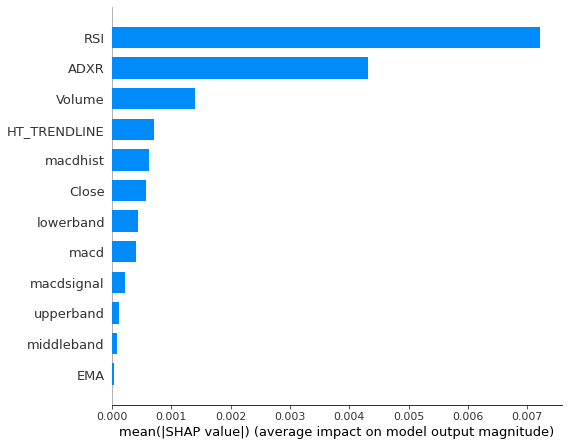

In [40]:
shap.summary_plot(shap_values[0], plot_type = 'bar',
                 feature_names = X_columns)

## ANN (Pytorch)

In [31]:
# Converting data to tensors
train_features = torch.tensor(X_train)
train_labels = torch.tensor(y_train.to_numpy())
 
val_features = torch.tensor(X_val)
val_labels = torch.tensor(y_val.to_numpy())

test_features = torch.tensor(X_test)
test_labels = torch.tensor(y_test.to_numpy())

# Create model
n_features = train_features.shape[1]
# 31
ann_pytorch = torch.nn.Sequential(torch.nn.Linear(n_features, 30),
                            torch.nn.Linear(30, 15),
                            torch.nn.ReLU(),
                            torch.nn.Linear(15, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 1),
                            torch.nn.Sigmoid())

# print(ann_pytorch)
ann_pytorch.to(device)

# Setting loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(ann_pytorch.parameters())

# Creating mini batches for training
n_batches = 2
train_features_batched = train_features.reshape(n_batches,
                                               int(train_features.shape[0]/n_batches),
                                               train_features.shape[1])
train_labels_batched = train_labels.reshape(n_batches,
                                            int(train_labels.shape[0]/n_batches))

In [32]:
summary(ann_pytorch, (12,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]             390
            Linear-2                   [-1, 15]             465
              ReLU-3                   [-1, 15]               0
            Linear-4                    [-1, 5]              80
              ReLU-5                    [-1, 5]               0
            Linear-6                    [-1, 1]               6
           Sigmoid-7                    [-1, 1]               0
Total params: 941
Trainable params: 941
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [33]:
n_epochs = 150
loss_list = []
val_acc_list = []
acc_list = []
validate_loss_list = []

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        optimizer.zero_grad()
         
        outputs = ann_pytorch(train_features_batched[batch_idx].float().to(device)).cpu()
         
     
        loss = criterion(outputs.flatten().float(),
                         train_labels_batched[batch_idx].float())
     
         
        loss.backward()
         
        optimizer.step()
         
    outputs = ann_pytorch(train_features.float().to(device)).cpu()
    y_train_pred = (outputs>0.5).float()
    train_acc = (y_train_pred.flatten().float() == train_labels.float()).float().sum()
    train_acc = train_acc / len(train_labels)
    acc_list.append(train_acc)
    
    validation_outputs = ann_pytorch(val_features.float().to(device)).cpu()
    y_val_pred = (validation_outputs>0.5).float()
    val_acc = (y_val_pred.flatten().float() == val_labels.float()).float().sum()
    val_acc = val_acc / len(val_labels)
    val_acc_list.append(val_acc)
         
    loss = criterion(outputs.flatten().float(),
                     train_labels.float())
     
    validate_loss = criterion(validation_outputs.flatten().float(),
                              val_labels.float())
     
    loss_list.append(loss.item())
     
    validate_loss_list.append(validate_loss)
     
    print("Epoch:", epoch + 1, "\nTrain Acc:", train_acc.item(), 
          "Train Loss:", loss.item(), "\nVal Acc:", val_acc.item(), 
         "Val Loss:", validate_loss.item())
    print('----------------------------------------------')
print('Finished Training')

Epoch: 1 
Train Acc: 0.5230022668838501 Train Loss: 0.6934282779693604 
Val Acc: 0.5241981744766235 Val Loss: 0.6924479603767395
----------------------------------------------
Epoch: 2 
Train Acc: 0.5230022668838501 Train Loss: 0.6931045055389404 
Val Acc: 0.5241981744766235 Val Loss: 0.6923613548278809
----------------------------------------------
Epoch: 3 
Train Acc: 0.5230022668838501 Train Loss: 0.6928315758705139 
Val Acc: 0.5241981744766235 Val Loss: 0.6922988295555115
----------------------------------------------
Epoch: 4 
Train Acc: 0.5230022668838501 Train Loss: 0.6926841139793396 
Val Acc: 0.5241981744766235 Val Loss: 0.6922396421432495
----------------------------------------------
Epoch: 5 
Train Acc: 0.5230022668838501 Train Loss: 0.6925804018974304 
Val Acc: 0.5241981744766235 Val Loss: 0.6922014951705933
----------------------------------------------
Epoch: 6 
Train Acc: 0.5230607390403748 Train Loss: 0.6924601793289185 
Val Acc: 0.5241981744766235 Val Loss: 0.69217282

Epoch: 50 
Train Acc: 0.5256598591804504 Train Loss: 0.691502571105957 
Val Acc: 0.5253937840461731 Val Loss: 0.6922063231468201
----------------------------------------------
Epoch: 51 
Train Acc: 0.5259782671928406 Train Loss: 0.6915051341056824 
Val Acc: 0.5256016850471497 Val Loss: 0.6922079920768738
----------------------------------------------
Epoch: 52 
Train Acc: 0.5260497331619263 Train Loss: 0.6915034055709839 
Val Acc: 0.525341808795929 Val Loss: 0.6922087669372559
----------------------------------------------
Epoch: 53 
Train Acc: 0.526134192943573 Train Loss: 0.6914927959442139 
Val Acc: 0.5256016850471497 Val Loss: 0.6922027468681335
----------------------------------------------
Epoch: 54 
Train Acc: 0.5260822176933289 Train Loss: 0.6914888620376587 
Val Acc: 0.5259655714035034 Val Loss: 0.6922022700309753
----------------------------------------------
Epoch: 55 
Train Acc: 0.5260237455368042 Train Loss: 0.6914817690849304 
Val Acc: 0.5256016850471497 Val Loss: 0.69219

Epoch: 98 
Train Acc: 0.5273168087005615 Train Loss: 0.6913008689880371 
Val Acc: 0.5259135961532593 Val Loss: 0.6921583414077759
----------------------------------------------
Epoch: 99 
Train Acc: 0.5273038148880005 Train Loss: 0.6912963390350342 
Val Acc: 0.5255497097969055 Val Loss: 0.6921597719192505
----------------------------------------------
Epoch: 100 
Train Acc: 0.5272713303565979 Train Loss: 0.6912943720817566 
Val Acc: 0.5252898335456848 Val Loss: 0.6921555399894714
----------------------------------------------
Epoch: 101 
Train Acc: 0.527323305606842 Train Loss: 0.6912927627563477 
Val Acc: 0.5252898335456848 Val Loss: 0.6921570897102356
----------------------------------------------
Epoch: 102 
Train Acc: 0.527323305606842 Train Loss: 0.6912875175476074 
Val Acc: 0.525341808795929 Val Loss: 0.6921567320823669
----------------------------------------------
Epoch: 103 
Train Acc: 0.5272648334503174 Train Loss: 0.6912863850593567 
Val Acc: 0.5250298976898193 Val Loss: 0.6

Epoch: 146 
Train Acc: 0.5281225442886353 Train Loss: 0.6911115050315857 
Val Acc: 0.5231584906578064 Val Loss: 0.6921839118003845
----------------------------------------------
Epoch: 147 
Train Acc: 0.5280640721321106 Train Loss: 0.6911093592643738 
Val Acc: 0.5232104659080505 Val Loss: 0.6921817064285278
----------------------------------------------
Epoch: 148 
Train Acc: 0.5282589793205261 Train Loss: 0.6911048889160156 
Val Acc: 0.5232104659080505 Val Loss: 0.6921828985214233
----------------------------------------------
Epoch: 149 
Train Acc: 0.5282784700393677 Train Loss: 0.6911001205444336 
Val Acc: 0.5229505896568298 Val Loss: 0.6921841502189636
----------------------------------------------
Epoch: 150 
Train Acc: 0.5283434391021729 Train Loss: 0.6910952925682068 
Val Acc: 0.5229505896568298 Val Loss: 0.6921848654747009
----------------------------------------------
Finished Training


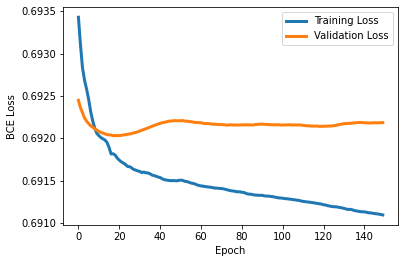

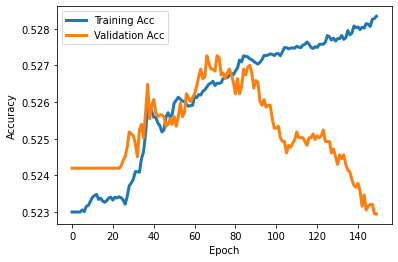

In [34]:
plt.plot(loss_list, linewidth=3)
plt.plot(validate_loss_list, linewidth=3)
plt.legend(("Training Loss", "Validation Loss"))
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.show()

plt.plot(acc_list, linewidth=3)
plt.plot(val_acc_list, linewidth=3)
plt.legend(("Training Acc", "Validation Acc"))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()



Precision Score : 0.5270375007452454


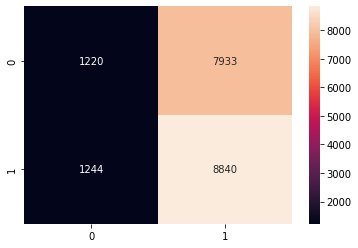

In [35]:
validation_outputs = ann_pytorch(val_features.float().to(device)).cpu()
y_val_pred = (validation_outputs>0.5).float()
val_acc = (y_val_pred.flatten().float() == val_labels.float()).float().sum()
val_acc = val_acc / len(val_labels)
print("\n\nPrecision Score :", precision_score(val_labels.float(), y_val_pred))
sns.heatmap(confusion_matrix(val_labels.float(), y_val_pred), annot = True, fmt = 'g')
plt.show()

In [18]:
# select a set of background examples to take an expectation over
background = train_features[np.random.choice(train_features.shape[0], 10000, replace=False)].float()
e = shap.DeepExplainer(ann_pytorch.cpu(), background)
shap_values = e.shap_values(val_features[0:500].float())

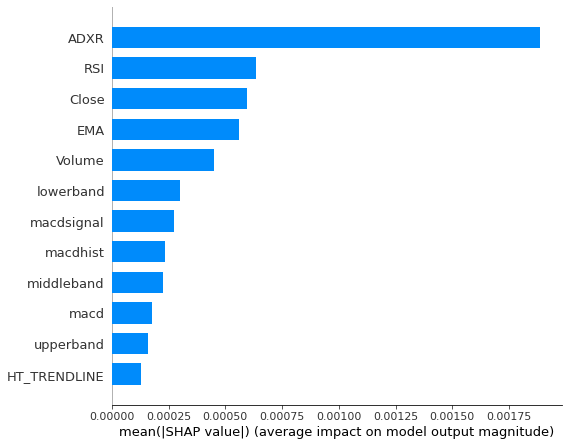

In [21]:
shap.summary_plot(shap_values, plot_type = 'bar',
                 feature_names = X_columns)

### Important Predictors for Baseline(5 Day)

1. p-values from Logistic Regression<br>
Close, Volume, HT_TRENDLINE, RSI<br>
2. XGBoost<br>
EMA, HT_TRENDLINE, lowerband, upperband, Close<br>
3. Random Forest<br>
Volume, macdhist, macdsignal, Close, ADXR<br>
4. ANN (Tensorflow)<br>
RSI, ADXR, Volume, HT_TRENDLINE, macdhist<br>
5. ANN (Pytorch)<br>
ADXR, RSI, Close, EMA, Volume


# Using indicators to create signals and use those as features. 

In [18]:
combined_data5

,Close,Volume,Company,upperband,middleband,lowerband,EMA,HT_TRENDLINE,ADXR,macd,macdsignal,macdhist,RSI,5_day_signal
63,136.449997,213214.0,ACC.NS,97.837867,94.155480,90.473093,94.300648,94.069083,20.883301,-0.563919,-0.282721,-0.281198,41.164954,1.0
64,139.050003,323951.0,ACC.NS,97.841394,94.187480,90.533566,94.260315,94.008932,19.511590,-0.508208,-0.327818,-0.180389,48.636735,0.0
65,137.750000,233684.0,ACC.NS,97.820271,94.116742,90.413214,94.166081,93.959786,18.928984,-0.528633,-0.367981,-0.160652,45.523675,1.0
66,138.149994,238998.0,ACC.NS,97.806956,94.076321,90.345687,94.095312,93.918973,18.981827,-0.517115,-0.397808,-0.119307,46.655071,1.0
68,137.649994,214666.0,ACC.NS,97.700940,93.983690,90.266439,93.945445,93.950812,18.731457,-0.511657,-0.437280,-0.074377,45.291460,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197010,13.300000,58240029.0,YESBANK.NS,13.403157,12.812500,12.221843,12.961994,12.787289,17.234221,0.080390,-0.015371,0.095761,61.395671,1.0
197011,13.350000,62818790.0,YESBANK.NS,13.457374,12.862500,12.267626,12.987027,12.831947,17.579568,0.099423,0.007588,0.091835,62.637755,1.0
197012,13.500000,61974559.0,YESBANK.NS,13.550365,12.907500,12.264635,13.020122,12.892281,18.176058,0.125168,0.031104,0.094064,66.155808,1.0
197013,13.600000,41676425.0,YESBANK.NS,13.638870,12.965000,12.291130,13.057533,12.948670,19.045481,0.151889,0.055261,0.096628,68.298896,1.0


For Volume, simply signalling 1 if volume is above rolling mean of 6 months else 0

In [ ]:
combined_data5['Rolling Average Volume'] = combined_data5['Volume'].rolling(180).mean()
combined_data5[['Volume','Rolling Average Volume']].iloc[0:6000].plot(kind = 'bar')

<AxesSubplot:>

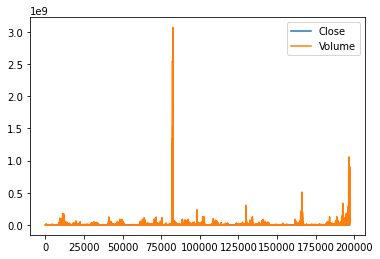

In [22]:
combined_data5[['Close', 'Volume']].plot(kind = 'line')